In [1]:
# Importing the necessary libraries
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# Loading dataset from Hugging Face and converting to a pandas DataFrame
dataset = load_dataset("lukebarousse/data_jobs")
df = dataset['train'].to_pandas()

# Converting the 'job_posted_date' column to datetime format
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])

# Converting 'job_skills' from stringified lists to actual Python lists
df['job_skills'] = df['job_skills'].apply(
    lambda x: ast.literal_eval(x) if pd.notna(x) else x
)

In [2]:
# Set the country to filter job data
v_job_country = 'India'

# Set the job title to focus on
v_job_title = 'Data Analyst'

# Set how many top skills to include in the charts or analysis
v_top_skills = 5

In [3]:
# Filter the data for jobs in the selected country
df_Ind = df[df['job_country'] == v_job_country].copy()

# Split the list of skills into separate rows (one skill per row)
df_Ind_explode = df_Ind.explode('job_skills')

In [4]:
# Count how often each skill appears for each job title
df_Ind_group = df_Ind_explode.groupby(['job_title_short', 'job_skills']).size()

# Turn the result into a DataFrame with a column named 'skill_count'
df_Ind_group = df_Ind_group.reset_index(name='skill_count')

# Sort the data so the most common skills appear first
df_Ind_group.sort_values(by='skill_count', ascending=False, inplace=True)

In [7]:
# Count how many job postings there are for each job title
job_counts = df_Ind['job_title_short'].value_counts().to_frame(name='job_counts')

# Merge the skill counts with the job counts based on job title
df_skill_prec = df_Ind_group.merge(job_counts, how='left', on='job_title_short')

# Calculate the percentage of jobs that mention each skill
df_skill_prec['skill_perc'] = 100 * (df_skill_prec['skill_count'] / df_skill_prec['job_counts'])

In [8]:
# Get the top 3 most common job titles from the dataset
job_titles = df['job_title_short'].value_counts().head(3).index.tolist()

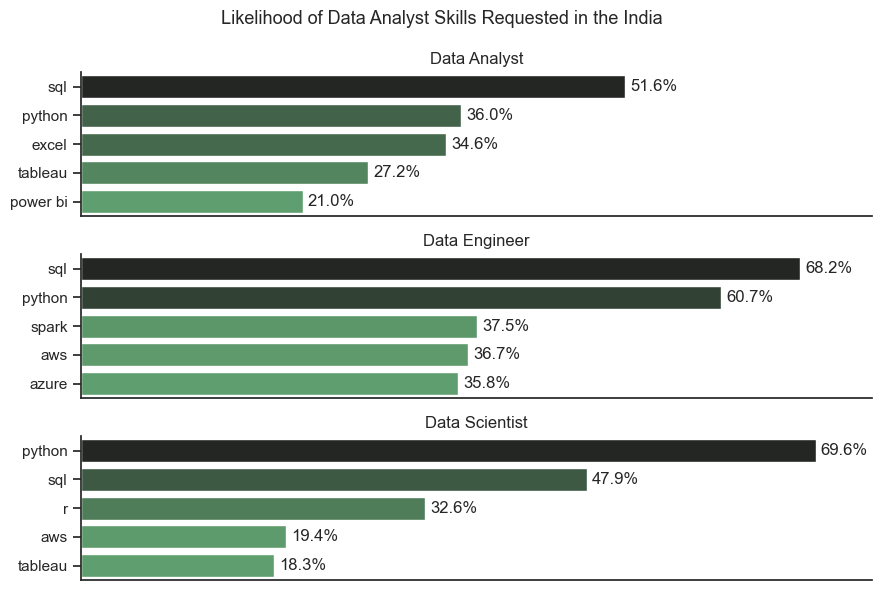

In [9]:
# Import formatter to display percentages on the x-axis
from matplotlib.ticker import PercentFormatter

# Create a figure with 3 stacked subplots
fig, ax = plt.subplots(3, 1, figsize=(9, 6))

# Set the visual style for all plots
sns.set_theme(style='ticks')

# Loop through each of the top 3 job titles
for i, job_title in enumerate(job_titles):
    # Filter the top skills for the current job title
    df_plot = df_skill_prec[df_skill_prec['job_title_short'] == job_title].head(v_top_skills)

    # Create a horizontal bar plot showing skill percentages
    sns.barplot(
        data=df_plot,
        x='skill_perc',
        y='job_skills',
        hue='skill_perc',
        palette='dark:g_r',
        ax=ax[i]
    )

    # Remove top/right plot borders
    sns.despine()

    # Remove the legend (not needed)
    ax[i].legend().remove()

    # Set the x-axis limit
    ax[i].set_xlim(0, 75)

    # Hide x-axis tick labels
    ax[i].set_xticks([])

    # Add percentage labels next to each bar
    for j, perc in enumerate(df_plot['skill_perc']):
        ax[i].text(df_plot['skill_perc'].iloc[j] + 0.5, j, f"{perc:.1f}%", va='center')

    # Set title and remove axis labels
    ax[i].set_title(job_title)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')

# Add a common title for all subplots
fig.suptitle(f"Likelihood of {v_job_title} Skills Requested in the {v_job_country}", fontsize=13)

# Adjust spacing between plots
fig.tight_layout()

# Show the final plot
plt.show()